# Classifying Road Quality Using Satellite Imagery in Metro Detroit
#### This .ipynb notebook walks through data augmentation, model creation, and model training. We employ a transfer learning approach and also experiment with different loss functions to find the optimal model for our road quality classification problem.

## Step 0: Setting up the notebook

Code to mount the Google drive where the data is stored. If this notebook is being run locally, this code can be changed to specify the current working directory. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CS231N_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import libraries 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torchvision.io as io

import seaborn as sns

from PIL import Image

from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchsummary import summary

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from PIL import Image



USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


#### Prepare the image transformations

In [3]:
# Training data will have some random data transformation steps to help prevent
# overfitting, these are not necessary during validation
image_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(size=256),
        transforms.Resize(size=224),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.CenterCrop(size=256),                         
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


#### Prepare the DataLoaders for the road quality classification task

In [4]:
### INSERT YOUR DIRECTORY PATHS HERE ###
### -------------------------------- ###
train_directory = '/content/drive/MyDrive/CS231N_project/train_cond'
valid_directory = '/content/drive/MyDrive/CS231N_project/val_cond'
### -------------------------------- ###

# Batch size
bs = 200

# Number of classes ("poor", "fair", "good")
num_classes = 3

# Load data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Size of data, to be used for calculating average Loss and accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the data loaded using DataLoader module
train_data = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=bs, shuffle=True)

# Print the train, validation and test set data sizes
train_data_size, valid_data_size


(2247, 456)

## Step 1: Create proposed model architectures

#### Download and modify pretrained models

The first two models we propose use a pretrained of ResNet50 pretrained on the ImageNet dataset and modify the final fully connected layers to produce our 3 class scores.

In [5]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the final layer
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Linear(128, 3)
)

model_CE = resnet50
model_ORD = resnet50 

Lastly, ensure that our models are on the GPU and read through the summary to ensure that we have the correct architecture

In [6]:
model_CE = model_CE.to(device=device)
model_ORD = model_ORD.to(device=device)

In [7]:
summary(model_CE, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Step 2: Create training and validation loops

### Create the optimizers

In [8]:
optimizer_CE = optim.Adam(model_CE.parameters(), lr=0.0005)
optimizer_ORD = optim.Adam(model_ORD.parameters(), lr=0.0005)

### Define loss functions

We will try out three different loss functions: cross entropy, vanilla MSE, and MSE with ordinal regression labels

In [9]:
# Use Cross Entropy loss as a starting point
def cross_entropy_loss(outputs, labels):
    loss_func = nn.CrossEntropyLoss()
    return(loss_func(outputs, labels))

In [10]:
# Defining a custom weighted MSE loss function
# Reweight the loss as needed to get better validation performance
def weighted_mse_loss(outputs, labels):
    weights = torch.tensor([1.0, 1.0, 1.0])
    weights = weights.to(device=device)
    loss = torch.mean(torch.square(outputs - labels) * weights[labels,])
    return loss

In [11]:
# Loss function when using ordinal regression labels 
def ordinal_regression_loss(predictions, targets):
    """Ordinal regression with encoding as in https://arxiv.org/pdf/0704.1028.pdf"""
    # Create out modified target with [batch_size, num_labels] shape
    modified_target = torch.zeros_like(predictions)
    # Fill in ordinal target function, i.e. 0 -> [1,0,0,...]
    for i, target in enumerate(targets):
        modified_target[i, 0:target+1] = 1

    return nn.MSELoss(reduction='none')(predictions, modified_target).sum()

### Define prediction functions

Each loss function has an associated prediction function: argmax for cross entropy, clamping for vanilla MSE, and cumprod-sum for ordinal regression MSE

In [12]:
def cross_entropy_preds(outputs):
    ret, predictions = torch.max(outputs.data, 1)
    return predictions

In [13]:
def mse_preds(outputs):
    predictions = torch.round(torch.clamp(outputs.data, min=0.0, max=2.0))
    return predictions  

In [14]:
def ordinal_regression_preds(outputs):
    """Convert ordinal predictions to class labels, e.g.
    [0.9, 0.1, 0.1, 0.1] -> 0
    [0.9, 0.9, 0.1, 0.1] -> 1
    [0.9, 0.9, 0.9, 0.1] -> 2
    """
    return (outputs > 0.5).cumprod(axis=1).sum(axis=1) - 1

### Create validation loop

In [15]:
def check_val_accuracy(model, data_loader, loss_func, predict_func):
    # No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        # Validation loop
        valid_loss = 0
        valid_acc = 0
        for j, (inputs, labels) in enumerate(valid_data):
              inputs = inputs.to(device)
              labels = labels.to(device)
              # Forward pass - compute outputs on input data using the model
              outputs = model(inputs)
              # Compute loss
              loss = loss_func(outputs, labels)
              # Compute the total loss for the batch and add it to valid_loss
              valid_loss += loss.item() * inputs.size(0)
              # Calculate validation accuracy
              predictions = predict_func(outputs.data)
              correct_counts = predictions.eq(labels.data.view_as(predictions))
              # Convert correct_counts to float and then compute the mean
              acc = torch.mean(correct_counts.type(torch.FloatTensor))
              # Compute total accuracy in the whole batch and add to valid_acc
              valid_acc += acc.item() * inputs.size(0)
        valid_acc = valid_acc / valid_data_size
        valid_loss = valid_loss / valid_data_size
        print("Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(valid_loss, valid_acc))
        return (valid_acc, valid_loss)

### Create training loop

In [16]:
def train_model(model, optimizer, loss_func, predict_func, epochs = 4): 
  train_accs = np.zeros(epochs)
  valid_accs = np.zeros(epochs)
  train_losses = np.zeros(epochs)
  valid_losses = np.zeros(epochs)

  model = model.to(device=device)
  epoch_num = 0
  for epoch in range(epochs):
        epoch_num += 1
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        model.train()
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        for i, (inputs, labels) in enumerate(train_data):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = loss_func(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            # Compute the accuracy
            predictions = predict_func(outputs.data)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            print("Iteration: {:03d}, Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        train_acc = train_acc / train_data_size
        train_loss = train_loss / train_data_size
        print("Training: Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss, train_acc))
        train_accs[epoch_num-1], train_losses[epoch_num-1] = train_acc, train_loss
        valid_accs[epoch_num-1], valid_losses[epoch_num-1] = check_val_accuracy(model, valid_data,
                                                                                loss_func, predict_func)
        # Print elapsed time for epoch    
        epoch_end = time.time()
        print("Epoch Time: {:.2f} secs".format(epoch_end - epoch_start)) 
  
  return (train_accs, train_losses, valid_accs, valid_losses)      

## Step 3: Train / Load the models

### Load models if already trained (skip run training loops)

In [17]:
### Commenting out this block so notebook can be run in full 
#model_CE.load_state_dict(torch.load('resnet50_CE.pth'))
#model_ORD.load_state_dict(torch.load('resnet50_ORD.pth'))

### Run training loops

In [18]:
# Cross entropy loss with ResNet50
accs_losses_CE = train_model(model_CE, optimizer_ORD, cross_entropy_loss, cross_entropy_preds, 5)
train_accs_CE, train_losses_CE, valid_accs_CE, valid_losses_CE = accs_losses_CE

Epoch: 1/5
Iteration: 000, Loss: 1.0934, Accuracy: 0.3600
Iteration: 001, Loss: 1.1423, Accuracy: 0.3100
Iteration: 002, Loss: 1.0828, Accuracy: 0.3450
Iteration: 003, Loss: 1.0605, Accuracy: 0.4250
Iteration: 004, Loss: 1.1463, Accuracy: 0.2450
Iteration: 005, Loss: 1.0181, Accuracy: 0.5000
Iteration: 006, Loss: 1.0183, Accuracy: 0.4800
Iteration: 007, Loss: 1.0105, Accuracy: 0.5350
Iteration: 008, Loss: 1.0009, Accuracy: 0.5900
Iteration: 009, Loss: 0.9710, Accuracy: 0.5450
Iteration: 010, Loss: 0.9507, Accuracy: 0.5800
Iteration: 011, Loss: 0.9077, Accuracy: 0.6596
Training: Loss: 1.0421, Accuracy: 0.4513
Validation: Loss: 0.9445, Accuracy: 0.4737
Epoch Time: 49.23 secs
Epoch: 2/5
Iteration: 000, Loss: 0.9132, Accuracy: 0.5750
Iteration: 001, Loss: 0.9370, Accuracy: 0.5100
Iteration: 002, Loss: 0.8706, Accuracy: 0.6650
Iteration: 003, Loss: 0.8302, Accuracy: 0.7450
Iteration: 004, Loss: 0.8880, Accuracy: 0.6100
Iteration: 005, Loss: 0.8576, Accuracy: 0.6550
Iteration: 006, Loss: 0.8

In [19]:
# Ordinal labels MSE loss with ResNet50
accs_losses_ORD = train_model(model_ORD, optimizer_ORD, ordinal_regression_loss, ordinal_regression_preds, 5)
train_accs_ORD, train_losses_ORD, valid_accs_ORD, valid_losses_ORD = accs_losses_ORD

Epoch: 1/5
Iteration: 000, Loss: 953.5976, Accuracy: 0.3450
Iteration: 001, Loss: 745.8730, Accuracy: 0.3500
Iteration: 002, Loss: 729.8889, Accuracy: 0.3150
Iteration: 003, Loss: 749.6046, Accuracy: 0.2200
Iteration: 004, Loss: 439.3638, Accuracy: 0.3100
Iteration: 005, Loss: 291.1886, Accuracy: 0.3500
Iteration: 006, Loss: 294.7910, Accuracy: 0.3600
Iteration: 007, Loss: 335.4920, Accuracy: 0.3600
Iteration: 008, Loss: 260.4725, Accuracy: 0.4150
Iteration: 009, Loss: 162.1795, Accuracy: 0.4100
Iteration: 010, Loss: 118.3767, Accuracy: 0.4700
Iteration: 011, Loss: 23.5892, Accuracy: 0.6596
Training: Loss: 452.7256, Accuracy: 0.3614
Validation: Loss: 161.0131, Accuracy: 0.3377
Epoch Time: 42.99 secs
Epoch: 2/5
Iteration: 000, Loss: 169.1347, Accuracy: 0.3550
Iteration: 001, Loss: 180.3802, Accuracy: 0.3850
Iteration: 002, Loss: 155.8426, Accuracy: 0.4050
Iteration: 003, Loss: 100.3470, Accuracy: 0.5200
Iteration: 004, Loss: 81.9946, Accuracy: 0.5950
Iteration: 005, Loss: 73.8755, Accur

### Visualize training results

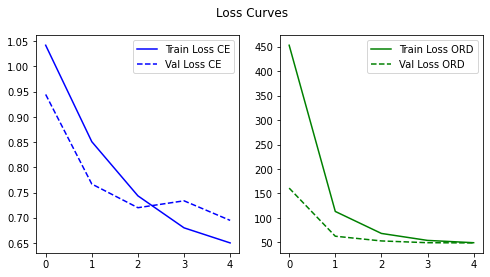

In [20]:
# Loss curves
plt.rcParams["figure.figsize"] = (8,4)
fig, ax = plt.subplots(1, 2)
ax[0].plot(np.arange(0,len(train_losses_CE)), train_losses_CE, label = "Train Loss CE", color='blue')
ax[0].plot(np.arange(0,len(valid_losses_CE)), valid_losses_CE, label = "Val Loss CE", color='blue', linestyle='dashed')
ax[1].plot(np.arange(0,len(train_losses_ORD)), train_losses_ORD, label = "Train Loss ORD", color='green')
ax[1].plot(np.arange(0,len(valid_losses_ORD)), valid_losses_ORD, label = "Val Loss ORD", color='green', linestyle='dashed')
ax[0].legend()
ax[1].legend()
plt.suptitle("Loss Curves")
plt.show()

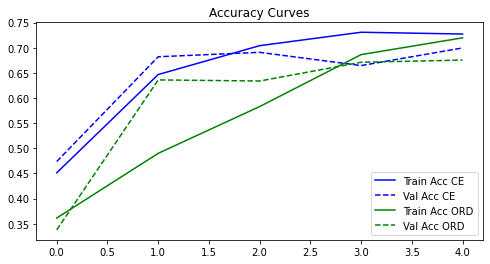

In [21]:
# Accuracy curves
plt.plot(np.arange(0,len(train_accs_CE)), train_accs_CE, label = "Train Acc CE", color='blue')
plt.plot(np.arange(0,len(valid_accs_CE)), valid_accs_CE, label = "Val Acc CE", color='blue', linestyle='dashed')
plt.plot(np.arange(0,len(train_accs_ORD)), train_accs_ORD, label = "Train Acc ORD", color='green')
plt.plot(np.arange(0,len(valid_accs_ORD)), valid_accs_ORD, label = "Val Acc ORD", color='green', linestyle='dashed')
plt.legend()
plt.title("Accuracy Curves")
plt.show()

## Step 4: Evaluate the models

### Create individual image predictions

In [22]:
# Predict function outputs raw, unnormalized class scores 
def predict(model, test_image_name): 
    transform = image_transforms['valid']
    test_image = Image.open(test_image_name).convert('RGB')
    plt.rcParams["figure.figsize"] = (4.5,4.5)
    plt.axis('off')
    plt.imshow(test_image)
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    with torch.no_grad():
        model.eval()
        # Model outputs probabilities
        ps = model(test_image_tensor)
        topk, topclass = ps.topk(1, dim=1)
        print("Predicted Road Quality", ps)

Predicted Road Quality tensor([[ 0.9414,  0.2177, -0.2323]], device='cuda:0')


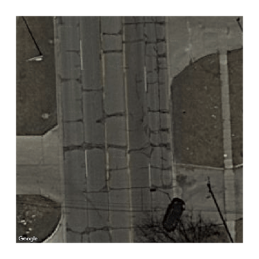

In [23]:
#map_339, 3
#map_551, 1
#map_35, 1
#map_193, 3,
#map_6928, 3,
predict(model_ORD, "/content/drive/MyDrive/CS231N_project/map_613.png")

### Visualize saliency maps

In [24]:
def compute_saliency_map(model, test_image_name, correct_class):
    transform = image_transforms['valid']
    test_image = Image.open(test_image_name).convert('RGB')
    test_image_tensor = transform(test_image)
    # Image underlying saliency map has been cropped and resized
    t1 = transforms.CenterCrop(size=256)
    t2 = transforms.Resize(size=224)
    test_image_cropped = t2(t1(test_image))

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)

    test_image_tensor.requires_grad_()
    # Retrieve score for correct class
    class_scores = model(test_image_tensor)
    correct_class_score = class_scores[0, correct_class - 1]

    # Do backpropagation to get the derivative of the output based on the image
    correct_class_score.backward()

    saliency, _ = torch.max(test_image_tensor.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(224, 224)

    # Plot the image side-by-side with saliency map overlay    
    plt.rcParams["figure.figsize"] = (8,5.5)
    extent = 0, 224, 0, 224
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(test_image)
    ax[0].axis('off')
    ax[1].imshow(test_image_cropped, extent = extent)
    ax[1].imshow(saliency.cpu(), cmap='hot', alpha = 0.5, extent = extent)
    ax[1].axis('off')
    plt.show()


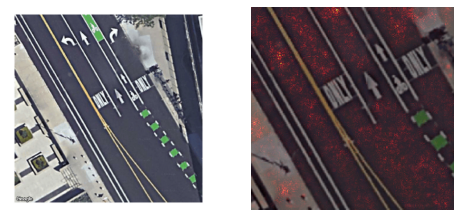

In [25]:
#map_339, 3
#map_551, 1
#map_35, 1
#map_193, 3,
#map_6928, 3,
compute_saliency_map(model_ORD, "/content/drive/MyDrive/CS231N_project/map_6928.png", 3)

### Visualize confusion matrices

In [26]:
def predict_batch(model, data_loader, predict_func):
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        for j, (inputs, labels) in enumerate(data_loader):
              inputs = inputs.to(device)
              labels = labels.to(device)
              # Forward pass - compute outputs on input data using the model
              outputs = model(inputs)
              predictions = predict_func(outputs.data)
              if j == 0:
                  preds_full = predictions
                  labels_full = labels
              else:
                  preds_full = torch.concat((preds_full, predictions))
                  labels_full = torch.concat((labels_full, labels))

    preds_full = preds_full.to(device)
    labels_full = labels_full.to(device)
    preds_full = preds_full.cpu().detach().numpy()
    labels_full = labels_full.cpu().detach().numpy()
    return (preds_full, labels_full)

In [27]:
valid_preds, valid_labels = predict_batch(model_CE, valid_data, cross_entropy_preds)
confusion_matrix(valid_labels, valid_preds, normalize = 'all')

array([[0.33114035, 0.        , 0.        ],
       [0.24780702, 0.08552632, 0.        ],
       [0.1995614 , 0.12938596, 0.00657895]])

In [28]:
valid_preds, valid_labels = predict_batch(model_ORD, valid_data, ordinal_regression_preds)
confusion_matrix(valid_labels, valid_preds, normalize = 'all')

array([[0.22807018, 0.09868421, 0.00438596],
       [0.03289474, 0.25      , 0.0504386 ],
       [0.00438596, 0.13377193, 0.19736842]])

### Visualize T-SNE plot

In [29]:
global view_embeds
def hook_fn(model, input, output):
    global view_embeds
    view_embeds = output

def get_embeddings(model, data_loader):
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        hook = model.fc[1].register_forward_hook(hook_fn)
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Use the forward hook to extract the embeddings
            outputs = model(inputs)
            if j == 0:
                embeds_full = view_embeds
                labels_full = labels
            else:
                embeds_full = torch.concat((embeds_full, view_embeds))
                labels_full = torch.concat((labels_full, labels))

        embeds_full = embeds_full.to(device)
        labels_full = labels_full.to(device)
        embeds_full = embeds_full.cpu().detach().numpy()
        labels_full = labels_full.cpu().detach().numpy()
        hook.remove()
        return (embeds_full, labels_full)

In [35]:
train_embeds, train_labels = get_embeddings(model_CE, train_data)

In [36]:
df = pd.DataFrame(train_embeds)
m = TSNE(learning_rate = 50, init = 'random')
tsne_features = m.fit_transform(df)

In [37]:
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
df['road_quality'] = train_labels

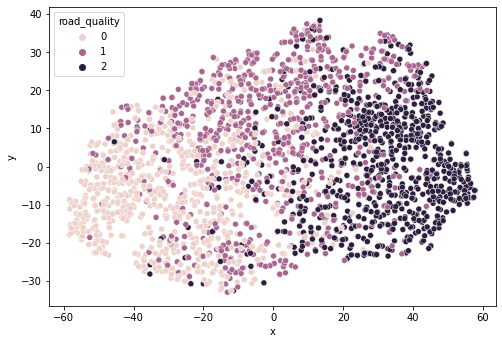

In [38]:
sns.scatterplot(x = "x", y = "y", hue = "road_quality", data = df)
plt.show()

## Step 5: Save the models

In [34]:
torch.save(model_CE.state_dict(), '/content/drive/MyDrive/CS231N_project/resnet50_CE.pth')
torch.save(model_ORD.state_dict(), '/content/drive/MyDrive/CS231N_project/resnet50_ORD.pth')